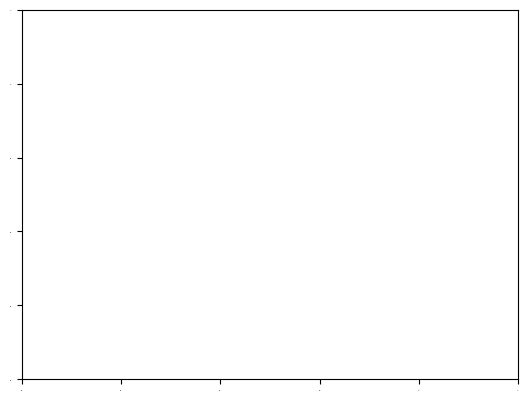

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

fontsize = 8
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.tick_params(axis='both', labelsize=1)

In [2]:
def load_fold_data(experiment_dir, fold, epoch):
    """
    Generalized function to load fold data from a given experiment directory.

    Args:
        experiment_dir (str): The directory path where the experiment data is stored.
        num_folds (int): Number of folds (e.g., 3 for fold_0, fold_1, fold_2).
        epoch (int): Epoch number to be loaded (e.g., 0 for epoch_0).

    Returns:
        pd.DataFrame: A DataFrame containing the concatenated data of all folds with fold information.
    """
    file_path = os.path.join(
        experiment_dir, f"fold_{fold}_epoch_{epoch}_metrics.csv"
    )

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["fold"] = fold
        return df
    else:
        print(f"Warning: File {file_path} does not exist.")

In [3]:
register_df = pd.read_csv("/net/scratch/cmosig/segmentation_meta/tiles_2025/register.csv")

In [4]:
experiment_dir = "/net/scratch/cmosig/experiment_dir_deadwood_segmentation/segformer_b5_new_metric/"

run_metrics_0 = load_fold_data( experiment_dir, 0, 104)
run_metrics_1 = load_fold_data( experiment_dir, 1, 104)
run_metrics_2 = load_fold_data( experiment_dir, 2, 104)

In [5]:
metrics_df = pd.concat([run_metrics_0, run_metrics_1, run_metrics_2], ignore_index=True)
metrics_df 

,tp,fp,fn,tn,precision,recall,f1,iou,accuracy,specificity,precision_0.5,recall_0.5,f1_0.5,iou_0.5,register_index,epoch,fold
0,0.0,44190.0,0.0,1004386.0,0.000000,0.000000,0.000000,0.000000,0.957857,0.957857,0.000000,0.000000,0.000000,0.000000,8895,104,0
1,0.0,0.0,0.0,1048576.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8896,104,0
2,1470.0,11708.0,129.0,1035269.0,0.111550,0.919325,0.198958,0.110468,0.988711,0.988817,0.111550,0.919325,0.198958,0.110468,8897,104,0
3,0.0,515.0,0.0,1048061.0,0.000000,0.000000,0.000000,0.000000,0.999509,0.999509,0.000000,0.000000,0.000000,0.000000,8898,104,0
4,4711.0,56305.0,2362.0,985198.0,0.077209,0.666054,0.138378,0.074332,0.944051,0.945939,0.077209,0.666054,0.138378,0.074332,8899,104,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319135,16954.0,4231.0,578.0,1026813.0,0.800283,0.967032,0.875791,0.779029,0.995414,0.995896,0.800283,0.967032,0.875791,0.779029,377337,104,2
319136,0.0,0.0,173.0,1047864.0,0.000000,0.000000,0.000000,0.000000,0.999835,1.000000,0.000000,0.000000,0.000000,0.000000,377338,104,2
319137,4645.0,10087.0,3164.0,1030680.0,0.315300,0.594826,0.412138,0.259555,0.987363,0.990308,0.315300,0.594826,0.412138,0.259555,2342,104,2
319138,1157.0,4915.0,106.0,1042398.0,0.190547,0.916073,0.315474,0.187277,0.995212,0.995307,0.190547,0.916073,0.315474,0.187277,2343,104,2


In [6]:
summed = metrics_df.groupby("fold").agg(
    {
    "tp" : "sum",
    "fp" : "sum",
    "fn" : "sum",
    }
)

precision = summed["tp"] / (summed["tp"] + summed["fp"])
recall = summed["tp"] / (summed["tp"] + summed["fn"])
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Overall Precision: {precision.mean()}, Recall: {recall.mean()}, F1: {f1.mean()}")

Overall Precision: 0.5117002157614785, Recall: 0.851368619750577, F1: 0.6388081914399012


In [7]:
# join the register with the metrics
register_metrics = pd.merge(
    register_df, metrics_df, right_on="register_index", left_index=True
)

register_metrics = register_metrics[register_metrics["resolution_bin"] != 0.28]
heat_df = register_metrics

In [8]:
biome_dict = {
    1: "Tropical and Subtropical Moist Broadleaf Forests",
    2: "Tropical and Subtropical Dry Broadleaf Forests",
    3: "Tropical and Subtropical Coniferous Forests",
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    7: "Tropical and Subtropical Grasslands, Savannas, and Shrublands",
    8: "Temperate Grasslands, Savannas, and Shrublands",
    9: "Flooded Grasslands and Savannas",
    10: "Montane Grasslands and Shrublands",
    11: "Tundra",
    12: "Mediterranean Forests, Woodlands, and Scrub",
    13: "Deserts and Xeric Shrublands",
    14: "Mangroves",
}

BIOMEGROUPINGS = {
    "(Sub) Tropical": [1, 2, 3, 14, 7],
    "Temperate": [4, 5, 8],
    "Boreal and Montane": [6, 11, 10],
    "Drylands": [12, 13, 9],
}

BIOMEGROUPINGS_INDEX_NAME = dict(zip(range(1, len(BIOMEGROUPINGS.keys()) + 1), BIOMEGROUPINGS.keys()))
BIOMEGROUPINGS_INDEX_NAME 

{1: '(Sub) Tropical', 2: 'Temperate', 3: 'Boreal and Montane', 4: 'Drylands'}

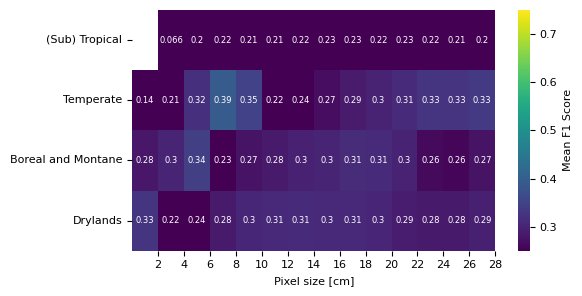

In [9]:
# print(heat_df.columns)
# Group by 'biome' and 'resolution_bin', calculating the mean of 'f1_0.5'

heatmap_data = (
    heat_df.groupby(["biome_group", "resolution_bin"])["f1_0.5"].mean().unstack()
)

# print(heat_df.groupby(["biome_group", "resolution_bin"])["f1_0.5"].mean().groupby("resolution_bin").mean())

# use the biome_dict to replace the biome numbers with the biome names
heatmap_data.index = heatmap_data.index.map(BIOMEGROUPINGS_INDEX_NAME)

# roud to three decimal places
heatmap_data = heatmap_data.round(3)
# Plot the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(
   heatmap_data, cmap="viridis", annot=True, cbar_kws=dict(label="Mean F1 Score"), annot_kws=dict(fontsize=6), vmin=0.25, vmax=0.75
)
plt.ylabel("")
plt.xlabel("Pixel size [cm]")
plt.tight_layout()

plt.xticks(np.arange(1, len(heatmap_data.columns)+1, 1), np.arange(2, 30, 2))

plt.savefig("/net/home/cmosig/projects/standing-deadwood/plots/performance_heatmap.pdf")
plt.show()

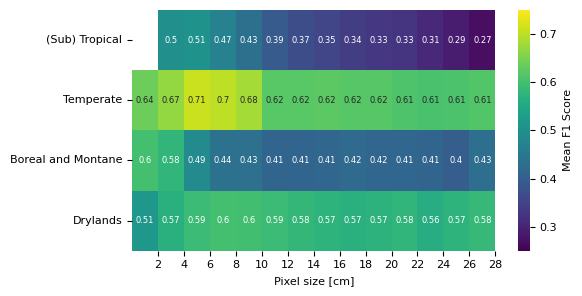

In [10]:
# print(heat_df.columns)
# Group by 'biome' and 'resolution_bin', calculating the mean of 'f1_0.5'

# aggregate and then compute f1
heatmap_data = (
    heat_df.groupby(["biome_group", "resolution_bin"]).agg(
                                                            {
                                                                "tp": "sum",
                                                                "fp": "sum",
                                                                "fn": "sum",
                                                            }).apply( lambda row: row["tp"] / (row["tp"] + 0.5 * (row["fp"] + row["fn"])) if (row["tp"] + 0.5 * (row["fp"] + row["fn"])) > 0 else 0, axis=1).unstack()
)

# print(heat_df.groupby(["biome_group", "resolution_bin"])["f1_0.5"].mean().groupby("resolution_bin").mean())

# use the biome_dict to replace the biome numbers with the biome names
heatmap_data.index = heatmap_data.index.map(BIOMEGROUPINGS_INDEX_NAME)

# roud to three decimal places
heatmap_data = heatmap_data.round(3)
# Plot the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(
   heatmap_data, cmap="viridis", annot=True, cbar_kws=dict(label="Mean F1 Score"), annot_kws=dict(fontsize=6), vmin=0.25, vmax=0.75
)
plt.ylabel("")
plt.xlabel("Pixel size [cm]")
plt.tight_layout()

plt.xticks(np.arange(1, len(heatmap_data.columns)+1, 1), np.arange(2, 30, 2))

plt.savefig("/net/home/cmosig/projects/standing-deadwood/plots/performance_heatmap_global.pdf")
plt.show()

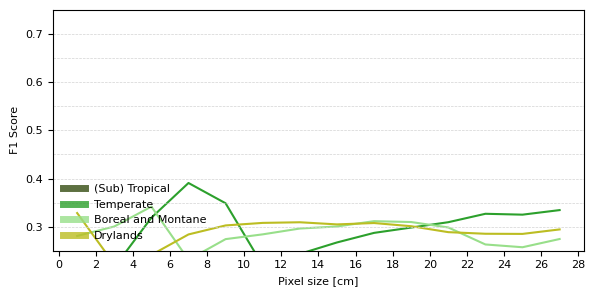

In [11]:
from matplotlib import lines as mlines

colors = {
    "(Sub) Tropical": "#344C11",  # color in words: "darkolivegreen"
    "Temperate": "#2ca02c",  # color in words: "green"
    "Boreal and Montane": "#98df8a",  # color in words: "palegreen"
    "Drylands": "#bcbd22",  # color in words: "gold"
}


# heatmap_data.plot(x="resolution_bin", y="metric")
temp_df = heat_df.groupby(["biome_group", "resolution_bin"])["f1_0.5"].mean().reset_index()

fig, ax = plt.subplots(figsize=(6, 3))
for k, group in temp_df.groupby("biome_group"):
    group.plot(x="resolution_bin", y="f1_0.5", kind="line", ax=ax, color=list(colors.values())[k-1])

ax.set_ylabel("F1 Score")
ax.set_xlabel("Pixel size [cm]")

ax.set_xticks(np.arange(-0.01, 0.28, 0.02))
ax.set_xticklabels(np.arange(0, 30,2))

ax.set_ylim(0.25, 0.75)

handles = [
    mlines.Line2D([], [], color=v, label=k, linewidth=5, alpha=0.8)
    for k, v in colors.items()
]

for y in np.arange(0.25, 0.76, 0.05):
    ax.axhline(y=y, color="lightgrey", linestyle="--", linewidth=0.5)

ax.legend(handles=handles,
              frameon=False,
              loc="lower left")

fig.tight_layout()

plt.savefig("/net/home/cmosig/projects/standing-deadwood/plots/performance_lineplot.pdf")

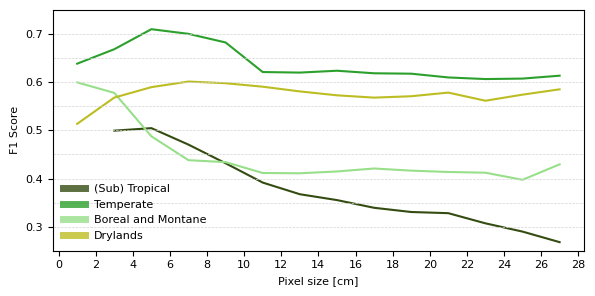

In [12]:
from matplotlib import lines as mlines

colors = {
    "(Sub) Tropical": "#344C11",  # color in words: "darkolivegreen"
    "Temperate": "#2ca02c",  # color in words: "green"
    "Boreal and Montane": "#98df8a",  # color in words: "palegreen"
    "Drylands": "#bcbd22",  # color in words: "gold"
}


temp_df = heat_df.groupby(["biome_group", "resolution_bin"]).agg(
    { 
        "tp": "sum",
        "fp": "sum",
        "fn": "sum",
    }).apply( lambda row: row["tp"] / (row["tp"] + 0.5 * (row["fp"] + row["fn"])) if (row["tp"] + 0.5 * (row["fp"] + row["fn"])) > 0 else 0, axis=1).reset_index()

temp_df.columns = ["biome_group", "resolution_bin", "f1_score"]

fig, ax = plt.subplots(figsize=(6, 3))
for k, group in temp_df.groupby("biome_group"):
    group.plot(x="resolution_bin", y="f1_score", kind="line", ax=ax, color=list(colors.values())[k-1])

ax.set_ylabel("F1 Score")
ax.set_xlabel("Pixel size [cm]")

ax.set_xticks(np.arange(-0.01, 0.28, 0.02))
ax.set_xticklabels(np.arange(0, 30,2))

handles = [
    mlines.Line2D([], [], color=v, label=k, linewidth=5, alpha=0.8)
    for k, v in colors.items()
]

ax.set_ylim(0.25, 0.75)

for y in np.arange(0.25, 0.76, 0.05):
    ax.axhline(y=y, color="lightgrey", linestyle="--", linewidth=0.5)

ax.legend(handles=handles,
              frameon=False,
              loc="lower left")

fig.tight_layout()

plt.savefig("/net/home/cmosig/projects/standing-deadwood/plots/performance_lineplot_global.pdf")